# Project: Naive Bayes / Sentiment Analysis Project 

# Step 1: Import Essential Libraries 

In [2]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import requests
import os
from pathlib import Path
import pandas as pd
import numpy as np
from numpy._core.defchararray import upper
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib


# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem
- Naive Bayes models are very useful when we want to analyze sentiment, classify texts into topics or recommendations, as the characteristics of these challenges meet the theoretical and methodological assumptions of the model very well.
- In this project you will practice with a dataset to create a review classifier for the Google Play store.

* **Variables**:
    - **package_name**. Name of the mobile application (categorical)
    - **review**. Comment about the mobile application (categorical)
    - **polarity**. Class variable (0 or 1), being 0 a negative comment and 1, positive (categorical numeric)


## 2.2 Inicitial Loading and Inspection

In [3]:
def setup_project_structure(base_path, subfolders):
    """Creates a standard data science directory tree."""
    for folder in subfolders:
        folder_path = Path(base_path) / folder
        folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Project structure initialized in: {base_path}")

def download_dataset_to_raw(url, full_path):
    """Downloads a file to a specific path."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(full_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
            
        print(f"Download successful! Saved to: {full_path}")
        return True
    except Exception as e:
        print(f"Download failed: {e}")
        return False

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")
        return False
    
# --- CONFIGURATION ---
BASE_DIR = "../data"
FOLDERS = ["raw", "processed", "interim"]
DATA_URL = "https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv"
TARGET_FILE = "playstore_reviews.csv"

# EXECUTION
# Build the whole house
setup_project_structure(BASE_DIR, FOLDERS)

# Put the data in the 'raw' room
RAW_FILE_PATH = Path(BASE_DIR) / "raw" / TARGET_FILE
download_dataset_to_raw(DATA_URL, RAW_FILE_PATH)

Project structure initialized in: ../data
Download successful! Saved to: ../data/raw/playstore_reviews.csv


True

In [4]:
# Define the full path again for reading
try:
    df = pd.read_csv(RAW_FILE_PATH, sep= None, engine= 'python')
    print("\nDataset loaded successfully into a DataFrame:")
except FileNotFoundError:
    print(f"\nError: File not found at {RAW_FILE_PATH}")


Dataset loaded successfully into a DataFrame:


# Step 3: Exploration and Data Cleaning

## 3.1 DataSet Dimension & Tipology Visibility

In [5]:
row, col = df.shape
print(f"The Dataset has {row} number of rows and {col} columns.")

The Dataset has 891 number of rows and 3 columns.


## 3.2 Top 5 Row View

In [6]:
top_five_data = df.head()
print("These are the DataSet top 5 columns view to be analized:")
print(tabulate(top_five_data, headers='keys', tablefmt='psql'))

These are the DataSet top 5 columns view to be analized:
+----+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|    | package_name        | review                                                                                                                                                                                                                                                                                                                                                                                                              

## 3.3 Data Types and Non-Nulls Values Overview.

In [7]:
print("This is the information about Non-Null and Dtype:\n================================================")
print(df.info())

This is the information about Non-Null and Dtype:
<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   package_name  891 non-null    str  
 1   review        891 non-null    str  
 2   polarity      891 non-null    int64
dtypes: int64(1), str(2)
memory usage: 21.0 KB
None


## 3.4 Check Unique

In [8]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df.nunique())

These are the Unique Values for each columns on the Dataset:
package_name     23
review          891
polarity          2
dtype: int64


## 3.5 Check for Duplicates Values

In [9]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df.duplicated().sum()
print(f"There is << {duplicate_val} >> duplicated value in the dataset.")

There is << 0 >> duplicated value in the dataset.


## 3.6 Duplicates Inspection

In [10]:
# Finding duplicates is a vital cleaning step.
duplicate_rows = df[df.duplicated(keep= False)]
print("Table with duplicates rows (in case they are and only for visibility):\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows (in case they are and only for visibility):
+----------------+----------+------------+
| package_name   | review   | polarity   |
|----------------+----------+------------|
+----------------+----------+------------+


## 3.7 Drop Duplicates

In [11]:
df = df.drop_duplicates().reset_index(drop= True)
print(df.shape)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

(891, 3)
+----+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|    | package_name        | review                                                                                                                                                                                                                                                                                                                                                                                                                                                              

## 3.8 Eliminate Irrelevant Information

- In this case, we have only 3 variables: 2 predictors and a dichotomous label. Of the two predictors, we are really only interested in the comment part. Therefore, the package_name variable should be removed.
- When we work with text, as in this case, it does not make sense to do an EDA, the process is different, since the only variable we are interested in is the one that contains the text. 
- In other cases where the text is part of a complex set with other numeric predictor variables and the prediction objective is different, then it makes sense to apply an EDA.

In [12]:
# Drop column 'package_name'.
df = df.drop('package_name', axis= 1)
print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|    | review                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |   polarity |
|----+------------------

# Step 4: Study of Variables and Content
## 4.1 Removing Spaces and Converting Text to Lowercase:

In [13]:
# 1. Strip whitespace and convert to lowercase
df['review'] = df['review'].str.strip().str.lower()

# 2. Check for empty strings or strings with only spaces
empty_string_count = (df['review'].str.strip() == "").sum()

print(f"Total rows: {len(df)}")
print(f"Empty string reviews: {empty_string_count}")

Total rows: 891
Empty string reviews: 0


## 4.2 Data Splitting

In [14]:
# We use the 'review' column as our feature and 'polarity' as our target
X = df['review']
y = df['polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 10)

print(f"Training set: {len(X_train)} reviews")
print(f"Testing set: {len(X_test)} reviews")

Training set: 712 reviews
Testing set: 179 reviews


## 4.3 Sparse Matrix (a table of numbers).

In [15]:
# 1. Initialize the CountVectorizer
# We'll remove 'stop words' (common words like 'the', 'is') to focus on sentiment
vec = CountVectorizer(stop_words= 'english')

# 2. Transform the text into numbers
# fit_transform on train, only transform on test!
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

# Just to peek at the data
print(X_train_vec[:5].toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Step 5. Build a Naive Bayes Model
 - As this is a data type of text data converted into counts and it follows a multinomial distribution.
 - Also as we have seen in the learning module, the features represent discrete counts.
 - the model I will choose for the first analysis is **MultinomialNB**

## 5.1 Testing the model with MultinomialNB

In [16]:
# 1. Initialize and Train the Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# 2. Predict on the test set
y_pred = model.predict(X_test_vec)

# 3. Show results
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

Accuracy Score: 79.33%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       119
           1       0.74      0.58      0.65        60

    accuracy                           0.79       179
   macro avg       0.78      0.74      0.75       179
weighted avg       0.79      0.79      0.79       179



## 5.2 Testing the model with BernoulliNB

In [17]:
# 1. Initialize the CountVectorizer
# We'll remove 'stop words' (common words like 'the', 'is') to focus on sentiment
vec_bNB = CountVectorizer(stop_words= 'english', binary= True) # binary= True --> aligning the data with the logic of BernoulliNB.

# 2. Transform the text into numbers
# fit_transform on train, only transform on test!
X_train_vec_bNB = vec_bNB.fit_transform(X_train)
X_test_vec_bNB = vec_bNB.transform(X_test)

# Just to peek at the data
print(X_train_vec_bNB[:5].toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
# 1. Initialize and Train the BernoulliNB Naive Bayes model
bnb_model = BernoulliNB()
bnb_model.fit(X_train_vec_bNB, y_train)

# 2. Predict on the test set
y_pred_bNB = bnb_model.predict(X_test_vec_bNB)

# 3. Show results
print(f"BernoulliNB Accuracy: {accuracy_score(y_test, y_pred_bNB):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_bNB))

BernoulliNB Accuracy: 73.18%

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82       119
           1       0.71      0.33      0.45        60

    accuracy                           0.73       179
   macro avg       0.72      0.63      0.64       179
weighted avg       0.73      0.73      0.70       179



### 5.2.1 Table comparison MultinomialNB vs. BernoulliNB
- The following table shoes comparison results between the two mentioned model as a conclusion and a column with the winner.

| Metric | MultinomialNB (Counts) | BernoulliNB (Binary) | Winner |
| :--- | :--- | :--- | :--- |
| **Overall Accuracy** | 79.33% | 73.18% | Multinomial |
| **Negative Recall (0)** | 90% | 93% | Bernoulli |
| **Positive Recall (1)** | 58% | 33% | Multinomial |

## 5.3 Testing the model with GaussianNB

In [19]:
# 1. We use the original non-binary CountVectorizer data
# 2. Convert Sparse to Dense (Required for Gaussian)
X_train_dense = X_train_vec.toarray()
X_test_dense = X_test_vec.toarray()

# 3. Initialize and Train
gnb_model = GaussianNB()
gnb_model.fit(X_train_dense, y_train)

# 4. Predict and Evaluate
y_pred_gnb = gnb_model.predict(X_test_dense)

print(f"GaussianNB Accuracy: {accuracy_score(y_test, y_pred_gnb):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_gnb))

GaussianNB Accuracy: 77.65%



Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83       119
           1       0.67      0.65      0.66        60

    accuracy                           0.78       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.77      0.78      0.78       179



In [20]:
X_train_dense

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(712, 3265))

## 5.4 Model Comparison & Justification Table

|Implementation	| Accuracy | Pos. Recall | Scalability | Theoretical Fit |
| :--- | :--- | :--- | :--- | :--- |
| MultinomialNB 1 | 79.33% | 58% | High (Sparse) | Excellent (Count data) |
| GaussianNB | 77.65% | 65% | Low (Dense) | Poor (Assumes Normal dist) |
| BernoulliNB | 73.18% | 33% | High (Sparse) | Good (Binary presence) |

- **Highest Overall Performance**: MultinomialNB achieved the highest accuracy (79.33%) and the best balance of F1-scores.
- **Efficiency and Scalability**: While GaussianNB showed a slightly better recall for positive reviews, it required converting the data into a dense array (.toarray()). This would cause memory failure. MultinomialNB works natively with sparse matrices.
- **Distribution Alignment**: As word counts are discrete and follow a multinomial distribution rather than a Gaussian (normal) distribution, MultinomialNB is theoretically the correct choice for text classification based on frequency.

# Step 6. Optimize Best Model Chosen (MultinomialNB) Using Random Forest
- Since MultinomialNB was the overall winner, let's see if a Random Forest can beat that 79.33% accuracy.

In [21]:
# 1. Initialize the Random Forest
# n_estimators = 100 is a good starting point (100 trees)
rf_model = RandomForestClassifier(n_estimators= 100, random_state= 10)

# 2. Train the model using the CountVectorizer data (Sparse is fine!)
rf_model.fit(X_train_vec, y_train)

# 3. Predict and Evaluate
y_pred_rf = rf_model.predict(X_test_vec)

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 81.56%

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       119
           1       0.75      0.67      0.71        60

    accuracy                           0.82       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.81      0.82      0.81       179



Top 10 most influential words in your model:
         word  importance
1690     love    0.027016
3032   update    0.015108
325      best    0.013640
1094      fix    0.013620
1245    great    0.013609
856     doesn    0.012378
1885   nepali    0.010570
1165      fun    0.010271
267   awesome    0.009875
339     birds    0.009220


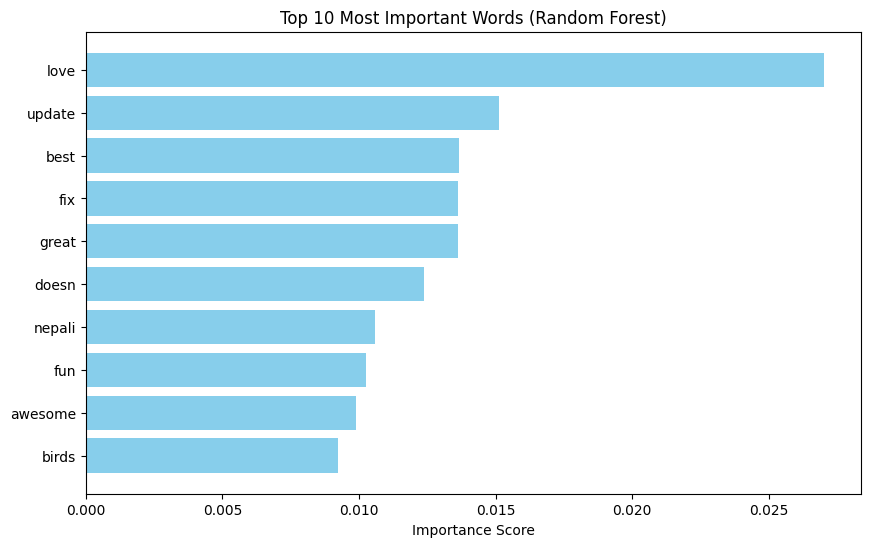

In [22]:
# 1. Get the importance scores from the winning Random Forest
importances = rf_model.feature_importances_

# 2. Get the word names from the vectorizer
words = vec.get_feature_names_out()

# 3. Create a DataFrame for easy sorting
feature_df = pd.DataFrame({'word': words, 'importance': importances})
feature_df = feature_df.sort_values(by='importance', ascending=False)

# 4. Display the Top 10
print("Top 10 most influential words in your model:")
print(feature_df.head(10))

# Optional: Visualize it
plt.figure(figsize=(10,6))
plt.barh(feature_df['word'].head(10), feature_df['importance'].head(10), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 10 Most Important Words (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

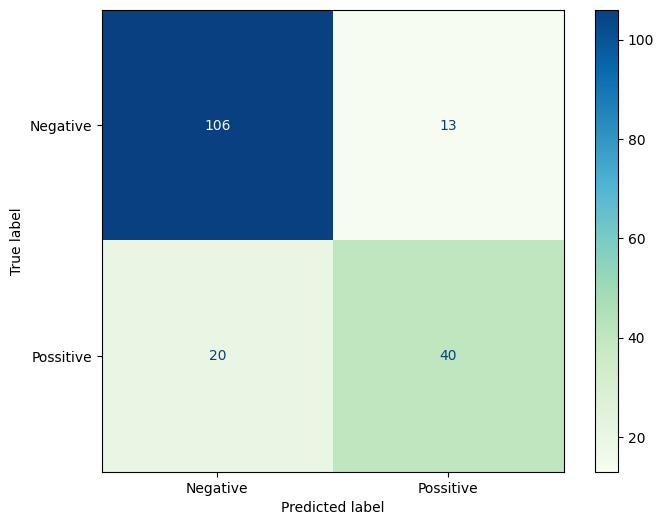

In [23]:
# Plotting the Confusion Matrix for be
fig, ax = plt.subplots(figsize= (8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels= ['Negative', 'Possitive'], cmap= 'GnBu', ax= ax)

### Confusion Matrix Comments:
- **True Possitive (40)**: The model predicted correclyt 40 out of 60 positives reviews.
- **True Negative (106)**: The model correctly identified 106. It has a high precision identifying negative comments. 
- **False Possitive (13)**: False Alarms, the model thought 13 were possitive and they're not.
- **False Negative (20)**: These are the missed possitive out of the true 60. The model wrongly predicted those.

## 6.1 Comparing the whole "Evolution" of the Project

| Model | Accuracy | Pos. Recall (Class 1) | Behavior |
| :--- | :--- | :--- | :--- |
| **BernoulliNB** | 73.18% | 33% | Too simple; ignores word frequency. |
| **GaussianNB** | 77.65% | 65% | Good recall | but wrong statistical assumption. |
| **MultinomialNB** | 79.33% | 58% | Very strong, fast, and theoretically sound. |
| **Random Forest** | 81.56% | 67% | **The Winner**. Captures complex word patterns. |

# Step 7. Saves the Winner Model

In [24]:
# joblib.dump is best for Random Forest / Naive Bayes. Best for models with large arrays/matrices.
# Saving the winning Random Forest model
joblib.dump(rf_model, '../models/best_sentiment_model_rf.pkl')

# Save the vectorizer too! 
# In case we need the SAME vectorizer to transform new text later.
joblib.dump(vec, '../models/count_vectorizer.pkl')

print("Champion model and vectorizer saved successfully!")

Champion model and vectorizer saved successfully!


# Step 8. Testing the Model
- I will run this code with some invented reviews to test the model prediction.

In [27]:
def predict_review_sentiment(new_review):
    # 1. Transform the raw string into the same numerical format as the training data
    # We use .transform(), NOT .fit_transform()
    review_vectorized = vec.transform([new_review])
    
    # 2. Get the prediction (0 or 1)
    prediction = rf_model.predict(review_vectorized)
    
    # 3. Get the probability (optional but cool to see)
    prob = rf_model.predict_proba(review_vectorized)
    
    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    confidence = np.max(prob) * 100
    
    print(f"Review: '{new_review}'")
    print(f"Result: {sentiment} ({confidence:.2f}% confidence)\n")

# --- Let's test it with some tricky ones ---
predict_review_sentiment("This app is amazing, it changed my life!")
predict_review_sentiment("Total waste of time. It crashes every five minutes and the ads are everywhere.")
predict_review_sentiment("It's not bad, but it could be better.")
predict_review_sentiment("The app shows me a lot of features and the look is nice. I wonder if they will upgrade functionallity next version.")


Review: 'This app is amazing, it changed my life!'
Result: Positive (75.00% confidence)

Review: 'Total waste of time. It crashes every five minutes and the ads are everywhere.'
Result: Negative (84.00% confidence)

Review: 'It's not bad, but it could be better.'
Result: Negative (52.00% confidence)

Review: 'The app shows me a lot of features and the look is nice. I wonder if they will upgrade functionallity next version.'
Result: Negative (50.00% confidence)



# Step 9. Explore other Alternatives
- As studied in the module, Random Forest uses parallel voting to stabilize predictions.
- I will also implement Gradient Boosting to see if a sequential approach, each tree learns from the errors of the previous one and could better capture the nuances in user sentiment.

In [26]:
# Initialize and train using the original CountVectorizer data. 
# Gradient Boosting: In Scikit-Learn, these models are optimized to handle sparse input directly. They are actually faster when you don't use .toarray()
# Gradien Boosting as gb

gb_model = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth= 3, random_state=10)
gb_model.fit(X_train_vec, y_train)

# Initial result
y_pred_gb = gb_model.predict(X_test_vec)

print(f"Gradien Boosting Accuracy: {accuracy_score(y_test, y_pred_gb):.2%}")
print("--- BASELINE GRADIENT BOOSTING RESULTS ---")
print(classification_report(y_test, y_pred_gb, target_names= ['Negative', 'Possitive']))

Gradien Boosting Accuracy: 72.63%
--- BASELINE GRADIENT BOOSTING RESULTS ---
              precision    recall  f1-score   support

    Negative       0.74      0.90      0.81       119
   Possitive       0.66      0.38      0.48        60

    accuracy                           0.73       179
   macro avg       0.70      0.64      0.65       179
weighted avg       0.71      0.73      0.70       179



## 9.1 Project Conclusion
- In this project, I **evaluated several classification architectures** to predict sentiment in Play Store reviews. 
- While **Multinomial Naive Bayes** provided a strong probabilistic baseline **(79.33%)**, it was ultimately outperformed by the **Random Forest Classifier (81.56%)**.
- The **Random Forest's success** is attributed to its ability to capture **non-linear relationships** between words as we have seen on the modules and virtual documentation.